In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union

In [3]:
data = import_results('results/pol_k3_m10.bin')
args = data['args']
motifs = data['motifs']
network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs)
for motif in motifs.values():
    log_motifs_table(motif.polarity_motifs)


Network file name: s1_data.xlsx
Sheet name: 5. Sign prediction
Filtering Neurons with polarity: ['+', '-']
Filtering Neurons with primary neurotransmitter: ['Glu', 'GABA', 'ACh', 0]
Polarity E/I ratio (before filtering): 3.122

Network properties:
	Neurons: 283
	Neurons with a Synapse: 283
	Synapses in the network: 11650

	Participating Nodes are neurons in a tuple with at least: 10 synapses
	Synapses in the graph: 7610
	Nodes: 223
	Edges: 371
	Average clustering coefficient: 0.036
	Average shortest path (undirected): 1.875
	Density: 0.007
	Polarity E/I ratio: 4.377
	Degree: Mean: 3.327 Std: 2.987 Median: 2.0 Max: 20 (node: RIAL)
	In-Degree: Mean: 1.664 Std: 2.668 Median: 0.0 Max: 15 (node: AVBR)
	Out-Degree: Mean: 1.664 Std: 1.607 Median: 1.0 Max: 10 (node: RIAL)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency threshold: 0.1

Sub Graph search using Algorithm: mfinder_i
Sub Graph search using k: 3
Allow self loops: False
Doing full Motif-Search:

In [4]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    total = sum(sizes)
    for s,l in zip(sizes, labels):
        print(f'{l}: {s}/{total}')

In [5]:
i = "74 ['-' '-' '-']"
i = "74"
if " " in i:
    i.index(" ")

# list(map(lambda x: offset=x.index(" "); f'{x[:offset]}\n{x[offset:]}', ids_))

In [6]:
def plot_motifs_z(motifs_list, motif_type, top=10):
    if not len(motifs_list):
        return
        
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    plt.figure()
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_, z_scores)

    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot of the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2, 2))
    fig.set_size_inches(num_of_graphs*2, 2)

    for idx, motif in enumerate(sorted_by_z):  
        ax_ = ax if num_of_graphs == 1 else ax[idx]
        ax_.axis('off')
        
        title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
        ax_.set_title(title, fontsize=7.5)

        graph = nx.DiGraph(motif.role_pattern)
        pos = nx.circular_layout(graph)
        nx.draw_networkx(graph, pos, ax=ax_)

        if motif.polarity:
            for role, pol in zip(motif.role_pattern, motif.polarity):
                s,t = role
                graph[s][t]['polarity']=pol

            edge_labels = nx.get_edge_attributes(graph, 'polarity')
            nx.draw_networkx_edge_labels(graph,pos,edge_labels=edge_labels, ax=ax_, font_color='k', font_weight='bold')

In [7]:
def plot_motif_roles(motif, top=5):
    roles = motif.node_roles.keys()
    num_of_roles = len(roles)
    if num_of_roles == 0:
        print(f'n_real: {motif.n_real}')
        return
    fig, ax = plt.subplots(nrows=1, ncols=num_of_roles, figsize=(num_of_roles*4, 4))
    
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center')
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}')
        

In [8]:
def node_properties(node: Union[str, int]):
    print(f'Node {node} properties:')

    if isinstance(node, str):
        node_idx = network.neuron_names.index(node)
    else:
        node_idx - node

    print(f'Degree: {network.graph.degree[node_idx]}')
    print(f'Out Degree: {network.graph.out_degree[node_idx]}')
    print(f'In Degree: {network.graph.in_degree[node_idx]}')
    print(f'Clustering coefficient: {round(nx.average_clustering(network.graph, nodes=[node_idx]), 3)}')

    
    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs.values()}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x:y for x,y in node_freq_in_motifs.items() if y!=0}
    
    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))
    plt.figure()
    plt.title(f'Appearance of node: {node} in sub-graphs')
    plt.ylabel('Frequency')
    plt.xlabel('Sub-graph id')

    plt.bar(freq_sorted.keys(), freq_sorted.values())
    plt.show()

motif: 5/13
anti-motif: 3/13
none: 5/13


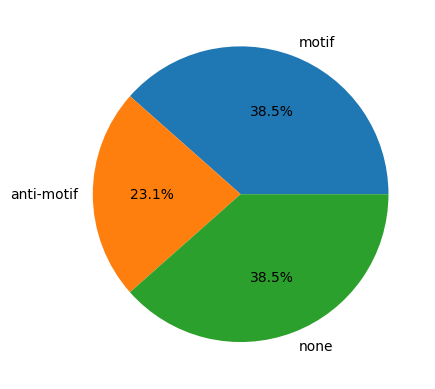

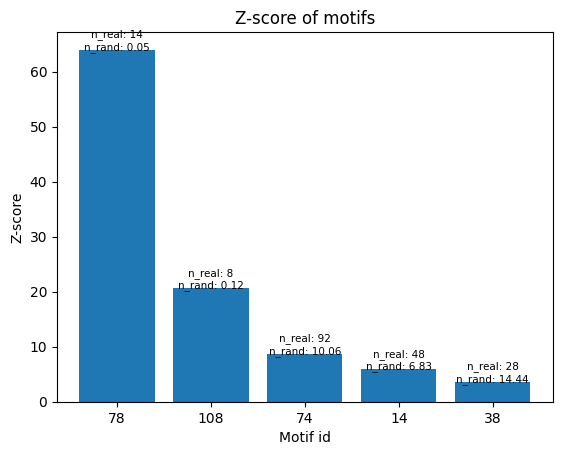

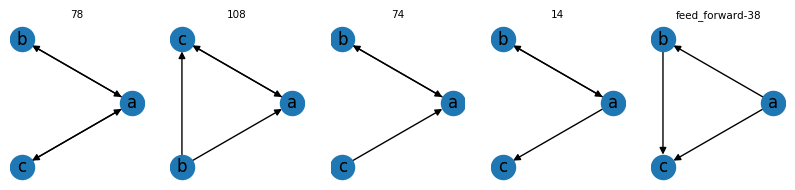

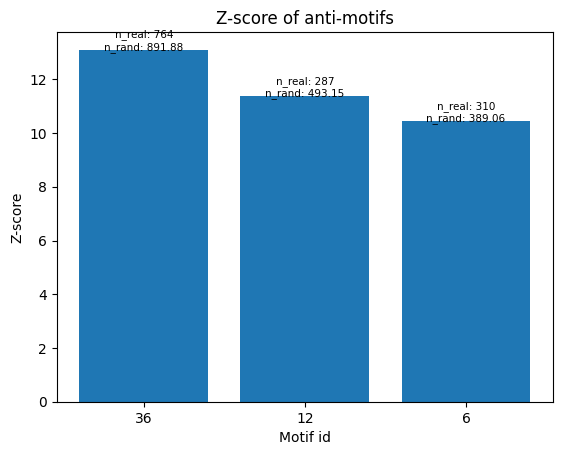

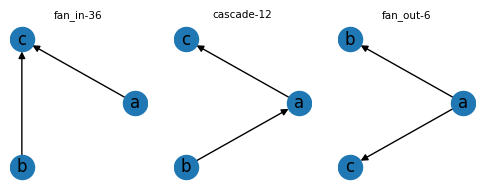

In [14]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif)
plot_motifs_z(anti_motifs_, MotifType.anti_motif)

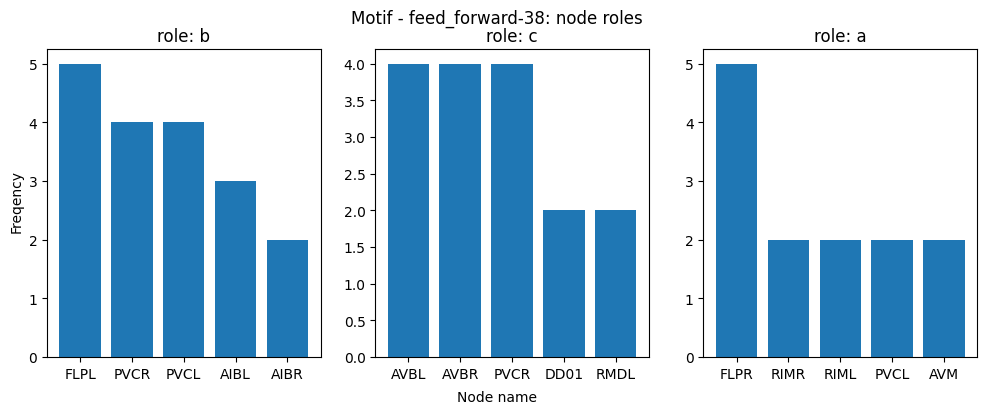

In [10]:
plot_motif_roles(motifs[38])

Node AVBR properties:
Degree: 15
Out Degree: 0
In Degree: 15
Clustering coefficient: 0.019


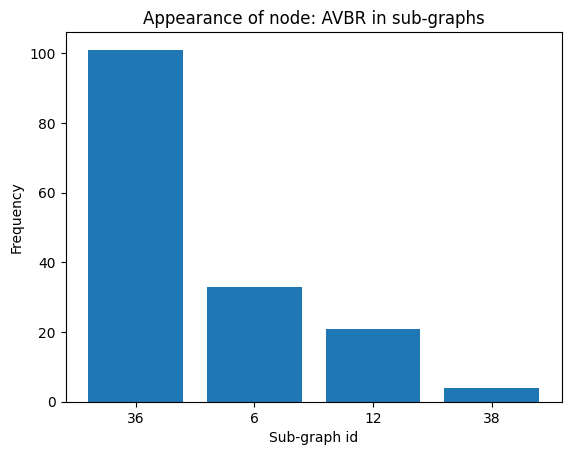

In [11]:
node_properties('AVBR')

Polarity

motif: 7/204
anti-motif: 4/204
none: 193/204


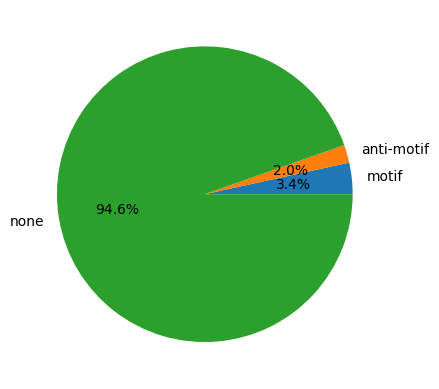

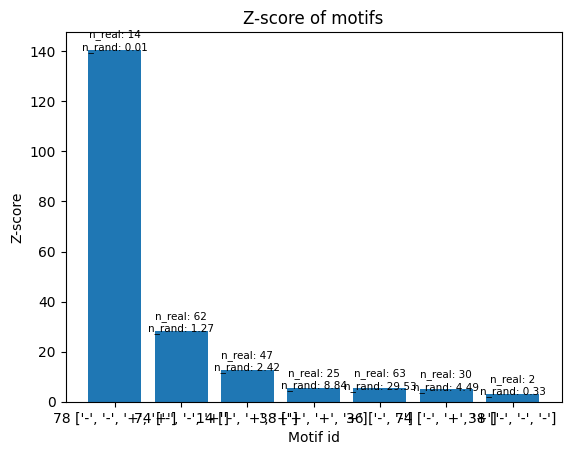

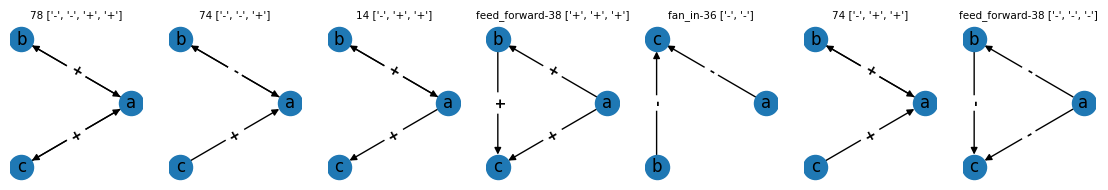

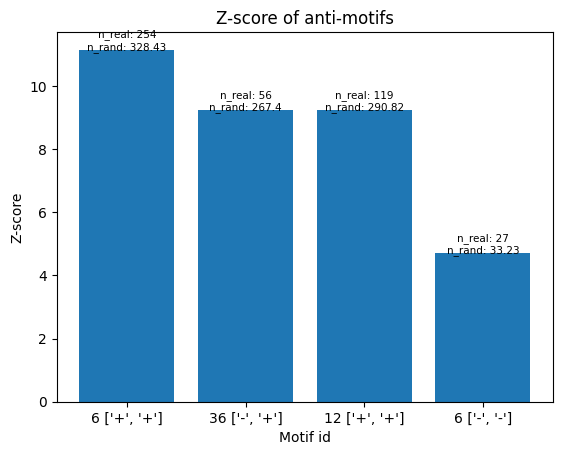

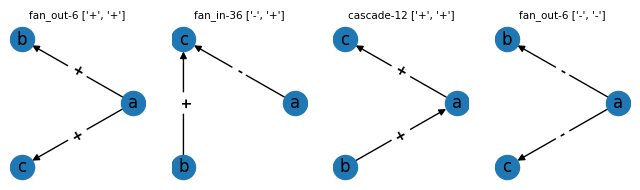

In [12]:
al_polarities = []
for m in motifs.values():
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif)
plot_motifs_z(anti_motifs_, MotifType.anti_motif)

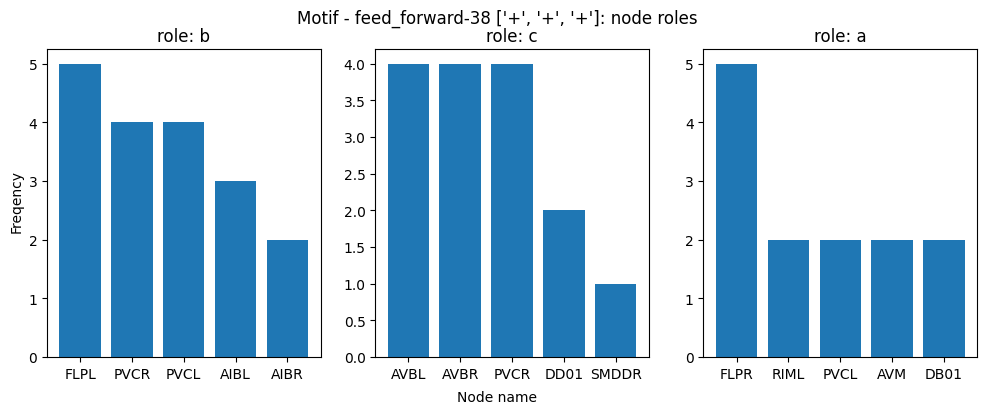

In [13]:
# 7 => bin: 111 => +++
plot_motif_roles(motifs[38].polarity_motifs[7])